# トレンドが線形、非線形で予測にどういう違いが出る？

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
# グラフを横長にする
plt.rcParams['figure.figsize'] = 15, 6
# 文字サイズの指定
plt.rcParams["font.size"] = 18

## データの読み込み
- 今回使用するデータ
    - Airline Passengers
        - 空港の乗客数の変動
    - CPIAPPNS (Consumer Price Index for All Urban Consumers: Apparel in U.S. City Average)
        - 消費者物価指数のこと（物価の変動がわかる指標）

In [3]:
dat1 = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',
                                    index_col='Month', parse_dates=True,  dtype='float')
dat2 = DataReader('CPIAPPNS', 'fred', start='1980').asfreq('MS')

### こんなデータ
- Passengers
    - 線形なトレンドを持つ
    - 季節性による振動幅が、時間経過に伴い大きくなっているように見える
- CPIAPPNS
    - 非線形なトレンドを持つ
    - 季節性による振動幅は、最初小さいが、後半はほぼ時不変に見える

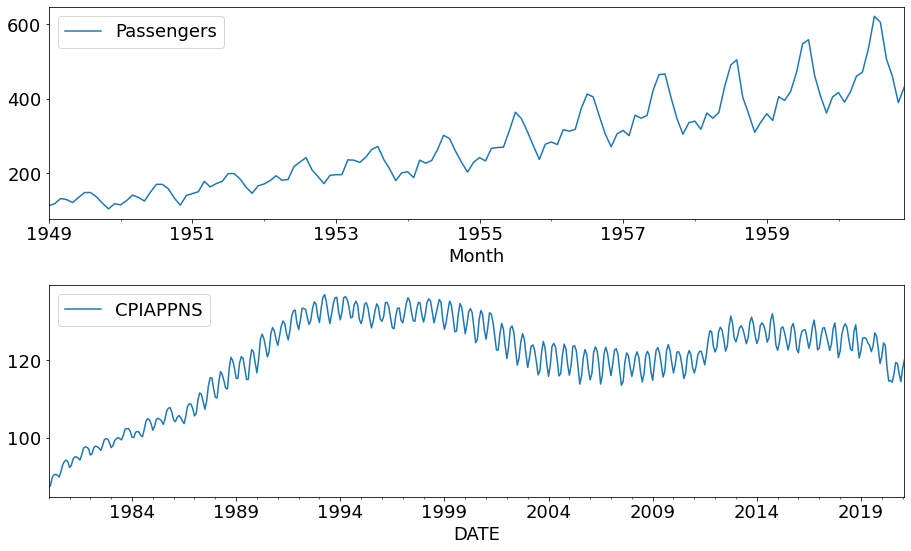

In [4]:
fig = plt.figure(figsize=(13,8))
ax1 = fig.add_subplot(211)
dat1.plot(ax=ax1)
ax2 = fig.add_subplot(212)
dat2.plot(ax=ax2)
plt.tight_layout()

## 周期を調べてみる
### 自己相関・偏自己相関（コレログラムのプロット）
- Passengers
    - 自己相関
        - 相関の強弱（コレログラムの凸凹）を読み取ると、12ヶ月の周期性があることが確認できる
    - 偏自己相関
        - 1次でスパイク（2次以上はほぼ相関がない）
            - 1次の自己回帰項あるいは、1次和分過程（単位根過程）と予想→元の時系列をみると単位根過程っぽい
            - 移動平均項を持つ場合は減衰していくので、このデータは移動平均項を持たない様子
        - 13次にも負のスパイクがあるが、これは線形トレンド＋周期性に起因している
        
    
- CPIAPPNS
    - 自己相関
        - ほとんどのラグで相関を持っている（トレンド起因と思われる）
        - 相関の強弱（コレログラムの凸凹）を読み取ると、6ヶ月の周期性があることが確認できる
    - 偏自己相関
        - 幾何級数的な減衰
            - 移動平均項を含むと思われる

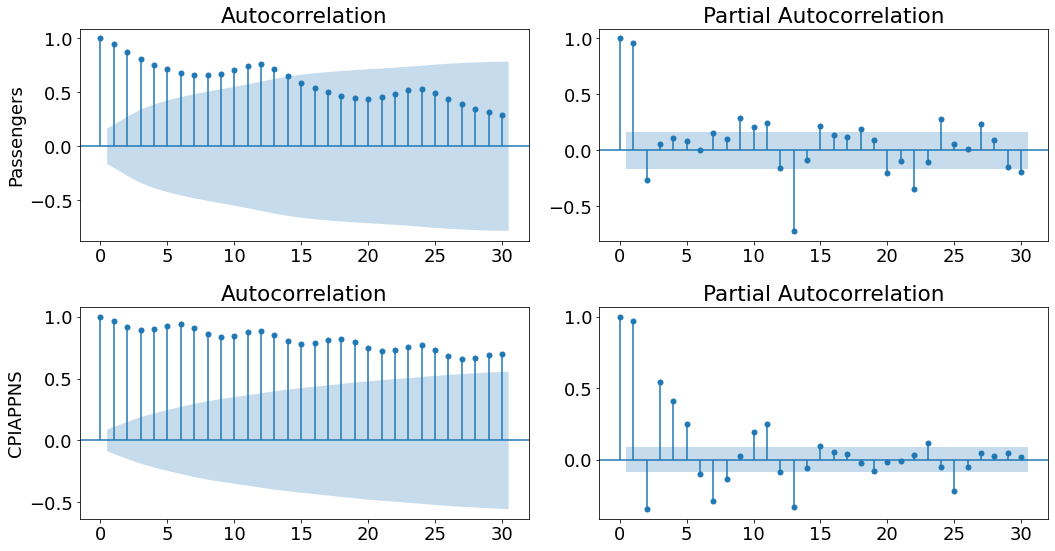

In [5]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(dat1, lags=30, ax=ax1)
ax1.set_ylabel('Passengers')
ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(dat1, lags=30, ax=ax2)

ax3 = fig.add_subplot(223)
fig = sm.graphics.tsa.plot_acf(dat2, lags=30, ax=ax3)
ax3.set_ylabel('CPIAPPNS')
ax4 = fig.add_subplot(224)
fig = sm.graphics.tsa.plot_pacf(dat2, lags=30, ax=ax4)
plt.tight_layout()

## モデルのフィッティング&予測
### 全データを学習に使用せずに、一部を使用する

In [17]:
train_dat1 = dat1[:'1958-12']
train_dat2 = dat2[:'2015-12']

### フィッティング
- トレンドがHPフィルタの出力に似るように、パラメータに制約を導入しながら推定
    - そのため、季節性に予測誤差のパラメータ 'sigma2.seasonal' のみ推定する
    
  
- summaryに関して
    - Passengers
        - p値は良さげ
        - 標準誤差（20.045）は若干大きい？
        - 残差に関する検定
    - CPIAPPNS
        - p値は5%を割ってるので、まあ良さげ
        - 標準誤差（0.006）も小さめで良い

In [122]:
mod1 = sm.tsa.UnobservedComponents(train_dat1, 'lltrend', seasonal=12, stochastic_seasonal=True)
mod2 = sm.tsa.UnobservedComponents(train_dat2, 'lltrend', seasonal=6, stochastic_seasonal=True)

res1= mod1.fit_constrained({'sigma2.irregular': 100, 'sigma2.level': 0, 'sigma2.trend': 100. / 100000})
res2 = mod2.fit_constrained({'sigma2.irregular': 1, 'sigma2.level': 0, 'sigma2.trend': 1. / 10000})

print(res1.summary(),
      '\n--------------------------------------------------------------------------------------------------------------------------\n',
      res2.summary())

                            Unobserved Components Results                            
Dep. Variable:                    Passengers   No. Observations:                  120
Model:                    local linear trend   Log Likelihood                -500.503
                   + stochastic seasonal(12)   AIC                           1003.006
Date:                       Tue, 30 Mar 2021   BIC                           1005.679
Time:                               13:52:26   HQIC                          1004.089
Sample:                           01-01-1949                                         
                                - 12-01-1958                                         
Covariance Type:                         opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
sigma2.irregular (fixed)   100.0000     

/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


## 獲得したトレンドと季節成分を見てみる

In [131]:
# Construct the smoothed level estimates
trend1 = pd.Series(res1.level.smoothed, index=train_dat1.index)
trend2 = pd.Series(res2.level.smoothed, index=train_dat2.index)

# Construct the smoothed estimates of the seasonal pattern
seasonal1 = pd.Series(res1.seasonal.smoothed, index=train_dat1.index)
seasonal2 = pd.Series(res2.seasonal.smoothed, index=train_dat2.index)

### トレンドはこんな感じ
- Passengers
    - 線形トレンドの獲得に成功している
    - 状態空間モデルを使用しないと、差分をとることで線形トレンドの除去を試みる必要があったが、<br>状態空間モデルでは勝手に獲得してくれる！
- CPIAPPNS
    - 非線形なトレンドの獲得もできている
        - これは、状態空間モデルを用いないと獲得が面倒そう → 状態空間モデルの利点
    - パラメータの調整こそあるが、Passengersと同一のモデルを用いても表現することができている！

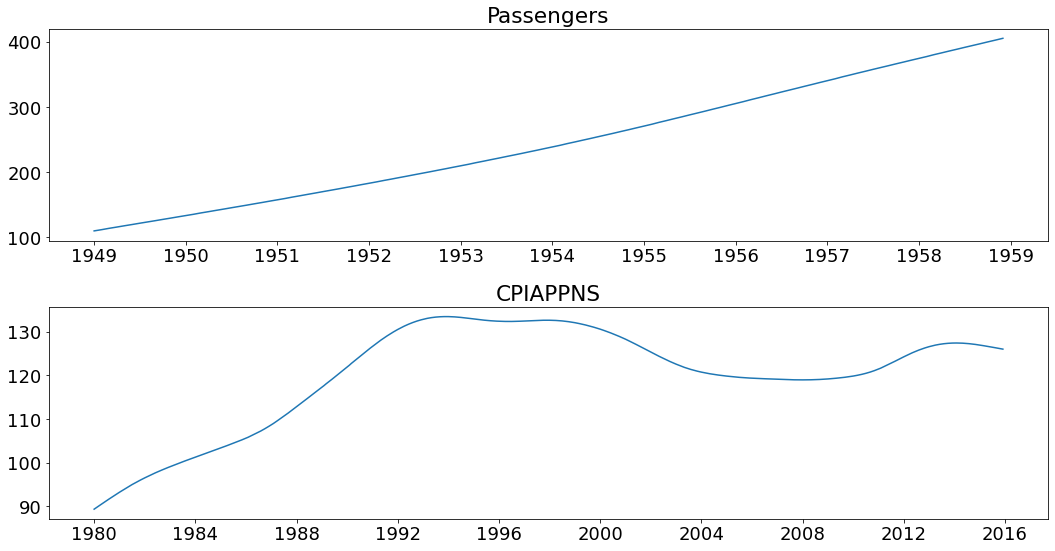

In [136]:
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(211)
ax1.plot(trend1)
ax1.set_title('Passengers')

ax2 = fig.add_subplot(212)
ax2.plot(trend2)
ax2.set_title('CPIAPPNS')
plt.tight_layout()

### 季節成分はこんな感じ
- 両者共に、季節成分の時間変化を捉えている様子

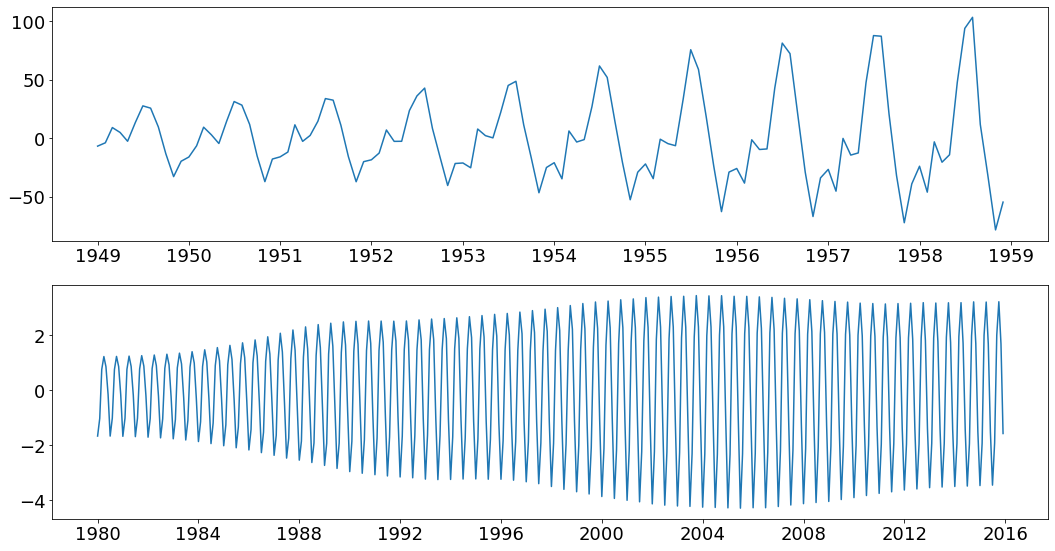

In [133]:
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(211)
ax1.plot(seasonal1)

ax2 = fig.add_subplot(212)
ax2.plot(seasonal2)
plt.tight_layout()

### 予測してみる
- Passengers
    - 正直なかなか、AR・MA系統ほどの予測精度は出ない印象

- だけど、一つのモデルでPassengers, CPIAPPNS共にある程度の精度を出せる（パラメータの制約次第では同等の精度が出る？）のが状態空間モデルの利点
- 複雑な系列であっても（今回のようにトレンドが非線形など）、状態空間モデルによりある程度はモデル化できるので、分析が楽
- 状態方程式・観測方程式の形状の見定めができるようになれば、もう少し精度が上がるのかもしれない


- 非線形なトレンドの予測は難しい様子
    - どう対策すべきか？
        - トレンドに起因する外部因子の情報があれば、それを利用するのが最も有効的か
        - そうでなければ、手元のデータで足掻くしかない？
            - 状態方程式・観測方程式の形状の検討
            - どういった、パラメータの制約を入れるか

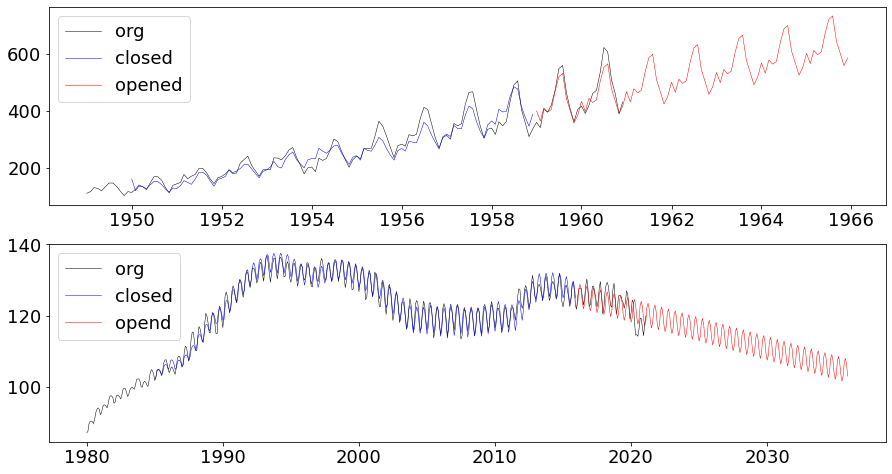

In [138]:
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(211)
pred1_closed = res1.predict('1950-01', '1958-12')
pred1_opened = res1.predict('1959-01', '1965-12')
plt.plot(dat1, 'k', linewidth=0.5, label='org')
plt.plot(pred1_closed, 'b', linewidth=0.5, label='closed')
plt.plot(pred1_opened, 'r', linewidth=0.5, label='opened')
plt.legend()

ax2 = fig.add_subplot(212)
pred2_closed = res2.predict('1985-01', '2015-12')
pred2_opened = res2.predict('2016-01', '2035-12')
plt.plot(dat2, 'k', linewidth=0.5, label='org')
plt.plot(pred2_closed, 'b', linewidth=0.5, label='closed')
plt.plot(pred2_opened, 'r', linewidth=0.5, label='opend')
plt.legend()